 **the second solution**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read Data

In [ ]:
import pandas as pd 

In [ ]:
npr=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Pubmed5k.xlsx")

In [ ]:
npr.head(10)

,ArticleID,Title,Abstract
0,34153941,Stable Coordination Variability in Overground ...,Coordination variability (CV) is commonly anal...
1,34153942,Weak Hip Strength Increases Dynamic Knee Valgu...,Clinical Scenario: Dynamic knee valgus (DKV) i...
2,34153964,Current and Future Projections of Amyotrophic ...,Various methodologies have been reported to as...
3,34153968,Disparities between Asian and Non-Asian Thromb...,As outcomes for acute ischemic stroke (AIS) va...
4,34153978,Maternal Factors Predicting Loss to Follow-Up ...,Because hearing loss in children can result in...
5,34153979,Testing the feasibility and acceptability of a...,"Despite growing numbers in the USA, immigrant ..."
6,34153980,Lupus nephritis and ANCA-associated vasculitis...,Historically the treatment of lupus nephritis ...
7,34153982,Precision medicine in diabetic nephropathy and...,Progressive chronic kidney disease (CKD) in in...
8,34153983,Precision medicine in immunoglobulin A nephrop...,Immunoglobulin A nephropathy (IgAN) is the mos...
9,34153984,Precision medicine in transplantation and hemo...,"In kidney transplantation, precision medicine ..."


In [ ]:
# Remove the columns
papers = npr.drop(columns=['ArticleID', 'Title'], axis=1)

# Print out the first rows of papers
papers.head()

,Abstract
0,Coordination variability (CV) is commonly anal...
1,Clinical Scenario: Dynamic knee valgus (DKV) i...
2,Various methodologies have been reported to as...
3,As outcomes for acute ischemic stroke (AIS) va...
4,Because hearing loss in children can result in...


# Data Cleaning

In [ ]:
# Load the regular expression library
import re

# Remove punctuation
papers['Abstract_processed'] = papers['Abstract'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['Abstract_processed'] = papers['Abstract_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['Abstract_processed'].head()


0    coordination variability (cv) is commonly anal...
1    clinical scenario: dynamic knee valgus (dkv) i...
2    various methodologies have been reported to as...
3    as outcomes for acute ischemic stroke (ais) va...
4    because hearing loss in children can result in...
Name: Abstract_processed, dtype: object

# **Tokenize words and Clean-up text**
tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

In [ ]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = papers.Abstract_processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['coordination', 'variability', 'cv', 'is', 'commonly', 'analyzed', 'to', 'understand', 'dynamical', 'qualities', 'of', 'human', 'locomotion', 'the', 'purpose', 'of', 'this', 'study', 'was', 'to', 'develop', 'guidelines', 'for', 'the', 'number', 'of', 'trials', 'required', 'to', 'inform']


# Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Remove Stopwords, Make Bigrams and Lemmatize**
The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
!python -m spacy download en_core_web_sm


     |████████████████████████████████| 12.0 MB 7.6 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

['coordination', 'variability', 'commonly', 'analyze', 'understand', 'dynamical', 'quality', 'locomotion', 'purpose', 'study', 'develop', 'guideline', 'number', 'trial', 'require', 'inform', 'calculation', 'stable', 'overground', 'locomotion', 'kinematic', 'capture', 'recreational', 'runner', 'perform', 'trial', 'prefer', 'fix', 'speed', 'walk']


# Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.

In [ ]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 3), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 3), (34, 2), (35, 2), (36, 2), (37, 1), (38, 1), (39, 4), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 3), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 3), (59, 2), (60, 2), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 8), (67, 1), (68, 1), (69, 2), (70, 1), (71, 2), (72, 2)]]


In [ ]:
id2word[0]

'achieve'

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('achieve', 1),
  ('analyze', 1),
  ('approach', 1),
  ('average', 1),
  ('aware', 1),
  ('calculated', 1),
  ('calculation', 1),
  ('capture', 1),
  ('coding', 2),
  ('commonly', 1),
  ('compare', 1),
  ('consequence', 1),
  ('coordination', 1),
  ('couple', 1),
  ('coupling', 1),
  ('cv', 3),
  ('determine', 1),
  ('develop', 1),
  ('differ', 1),
  ('difference', 1),
  ('dynamical', 1),
  ('few', 1),
  ('finding', 1),
  ('fix', 2),
  ('future', 1),
  ('guideline', 1),
  ('healthy', 1),
  ('individual', 1),
  ('inform', 2),
  ('insufficient', 1),
  ('joint', 1),
  ('kinematic', 1),
  ('lead', 1),
  ('locomotion', 3),
  ('mean', 2),
  ('minimum', 2),
  ('mode', 2),
  ('modify', 1),
  ('notable', 1),
  ('number', 4),
  ('output', 1),
  ('overall', 1),
  ('overground', 1),
  ('oversight', 1),
  ('perform', 1),
  ('phase', 2),
  ('population', 1),
  ('prefer', 2),
  ('purpose', 1),
  ('quality', 1),
  ('recreational', 1),
  ('require', 3),
  ('research', 1),
  ('researcher', 1),
  ('run

# Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics in LDA model

In [ ]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.025*"use" + 0.017*"study" + 0.016*"base" + 0.014*"model" + 0.012*"result" '
  '+ 0.010*"datum" + 0.010*"provide" + 0.008*"system" + 0.008*"method" + '
  '0.008*"identify"'),
 (1,
  '0.033*"study" + 0.023*"risk" + 0.023*"high" + 0.020*"group" + 0.018*"year" '
  '+ 0.016*"age" + 0.015*"low" + 0.014*"factor" + 0.013*"rate" + '
  '0.013*"associate"'),
 (2,
  '0.026*"effect" + 0.020*"increase" + 0.014*"level" + 0.012*"concentration" + '
  '0.011*"show" + 0.010*"result" + 0.010*"reduce" + 0.010*"high" + '
  '0.010*"treatment" + 0.009*"study"'),
 (3,
  '0.016*"water" + 0.008*"image" + 0.007*"implant" + 0.007*"surface" + '
  '0.007*"show" + 0.007*"device" + 0.007*"parameter" + 0.006*"area" + '
  '0.006*"measurement" + 0.006*"removal"'),
 (4,
  '0.014*"stress" + 0.014*"paper" + 0.010*"parent" + 0.009*"scale" + '
  '0.009*"literature" + 0.009*"network" + 0.008*"anxiety" + 0.008*"online" + '
  '0.008*"pandemic" + 0.008*"behaviour"'),
 (5,
  '0.017*"specie" + 0.015*"gene" + 0.012*"protei

# Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [ ]:
from gensim.models import CoherenceModel

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)


Perplexity:  -8.275261718251372
Coherence Score:  0.4300551511466586


# How to find the optimal number of topics for LDA?
My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                num_topics=num_topics,
                                                id2word=dictionary, 
                                                random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=50, step=1)


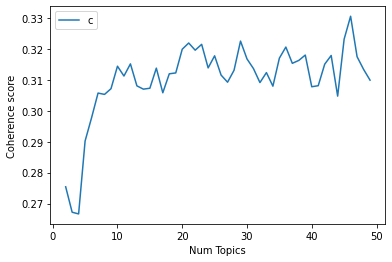

In [ ]:
# Show graph
import matplotlib.pyplot as plt
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

# Choosing the optimal number of LDA topics

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2754
Num Topics = 3  has Coherence Value of 0.2672
Num Topics = 4  has Coherence Value of 0.2667
Num Topics = 5  has Coherence Value of 0.2902
Num Topics = 6  has Coherence Value of 0.2977
Num Topics = 7  has Coherence Value of 0.3057
Num Topics = 8  has Coherence Value of 0.3053
Num Topics = 9  has Coherence Value of 0.3071
Num Topics = 10  has Coherence Value of 0.3144
Num Topics = 11  has Coherence Value of 0.3112
Num Topics = 12  has Coherence Value of 0.3152
Num Topics = 13  has Coherence Value of 0.3081
Num Topics = 14  has Coherence Value of 0.307
Num Topics = 15  has Coherence Value of 0.3073
Num Topics = 16  has Coherence Value of 0.3138
Num Topics = 17  has Coherence Value of 0.3058
Num Topics = 18  has Coherence Value of 0.312
Num Topics = 19  has Coherence Value of 0.3122
Num Topics = 20  has Coherence Value of 0.3199
Num Topics = 21  has Coherence Value of 0.3219
Num Topics = 22  has Coherence Value of 0.3196
Num Topics = 23  has Co

I will choose the model with 20 topics itself.

In [ ]:
# Select the model and print the topics
optimal_model = model_list[8]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.019*"patient" + 0.015*"study" + 0.007*"use" + 0.006*"identify" + 0.006*"result" + 0.005*"test" + 0.005*"analysis" + 0.005*"treatment" + 0.005*"high" + 0.005*"disease"'),
 (1,
  '0.028*"patient" + 0.013*"study" + 0.010*"use" + 0.007*"include" + 0.006*"year" + 0.006*"age" + 0.005*"group" + 0.005*"high" + 0.005*"risk" + 0.005*"low"'),
 (2,
  '0.018*"study" + 0.010*"use" + 0.009*"risk" + 0.008*"group" + 0.007*"high" + 0.006*"patient" + 0.006*"factor" + 0.006*"model" + 0.005*"include" + 0.005*"compare"'),
 (3,
  '0.011*"study" + 0.008*"use" + 0.008*"high" + 0.006*"patient" + 0.005*"model" + 0.004*"datum" + 0.004*"change" + 0.004*"level" + 0.004*"risk" + 0.004*"effect"'),
 (4,
  '0.011*"use" + 0.007*"study" + 0.006*"base" + 0.005*"model" + 0.005*"method" + 0.005*"cell" + 0.005*"show" + 0.005*"effect" + 0.005*"result" + 0.005*"high"'),
 (5,
  '0.008*"protein" + 0.008*"cell" + 0.006*"study" + 0.005*"treatment" + 0.005*"show" + 0.005*"high" + 0.005*"use" + 0.005*"result" + 0.004*"incr

# visualize the clusters of documents in a 2D space using t-SNE .

In [ ]:
import matplotlib.colors as mcolors
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2755 samples in 0.003s...
[t-SNE] Computed neighbors for 2755 samples in 0.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2755
[t-SNE] Computed conditional probabilities for sample 2000 / 2755
[t-SNE] Computed conditional probabilities for sample 2755 / 2755
[t-SNE] Mean sigma: 0.069056


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.417358
[t-SNE] KL divergence after 1000 iterations: 1.067237


# **Word Clouds of Top 10 Keywords in Each Topic**

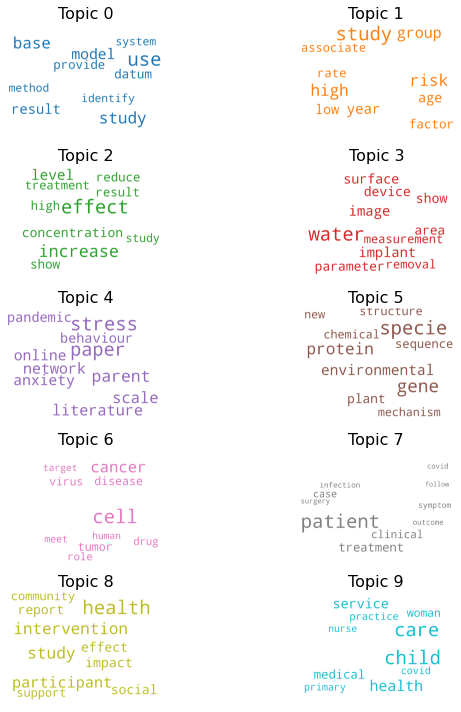

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Finding the dominant topic in each sentence.
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=papers['Abstract_processed'])


In [ ]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(30)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.9701,"study, use, high, patient, model, datum, chang...",coordination variability (cv) is commonly anal...
1,1,2.0,0.8091,"study, use, risk, group, high, patient, factor...",clinical scenario: dynamic knee valgus (dkv) i...
2,2,0.0,0.7339,"patient, study, use, identify, result, test, a...",various methodologies have been reported to as...
3,3,2.0,0.4577,"study, use, risk, group, high, patient, factor...",as outcomes for acute ischemic stroke (ais) va...
4,4,2.0,0.4158,"study, use, risk, group, high, patient, factor...",because hearing loss in children can result in...
5,5,2.0,0.4795,"study, use, risk, group, high, patient, factor...",despite growing numbers in the usa immigrant p...
6,6,7.0,0.7146,"patient, level, effect, use, increase, show, r...",historically the treatment of lupus nephritis ...
7,7,0.0,0.8642,"patient, study, use, identify, result, test, a...",progressive chronic kidney disease (ckd) in in...
8,8,0.0,0.3611,"patient, study, use, identify, result, test, a...",immunoglobulin a nephropathy (igan) is the mos...
9,9,0.0,0.6715,"patient, study, use, identify, result, test, a...",in kidney transplantation precision medicine h...


# Find the most representative document for each topic.
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [ ]:

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9940,"patient, study, use, identify, result, test, a...",background patients with adult congenital hear...
1,1.0,0.9947,"patient, study, use, include, year, age, group...",this study aimed to explore the clinical effic...
2,2.0,0.9959,"study, use, risk, group, high, patient, factor...",treatment inertia is a recognised barrier to b...
3,3.0,0.9951,"study, use, high, patient, model, datum, chang...",high-elevation grasslands worldwide provide es...
4,4.0,0.9937,"use, study, base, model, method, cell, show, e...",brain-machine interfaces (bmis) help the disab...
5,5.0,0.9940,"protein, cell, study, treatment, show, high, u...",this study focuses on the processes occurring ...
6,6.0,0.9931,"use, cell, protein, study, tumor, result, vacc...",most cancers become more dangerous by the outg...
7,7.0,0.9941,"patient, level, effect, use, increase, show, r...",owing to its aggressive biological behavior th...
8,8.0,0.9947,"health, study, use, intervention, care, includ...",to inform implementation and future research t...
9,9.0,0.9929,"group, patient, high, use, study, effect, low,...",to evaluate the efficacy of intravaginal elect...
